In [1]:
from collections import OrderedDict
from copy import copy
from sympy import Symbol
import QDYN
from QDYN.pulse import blackman
from QDYN.shutil import mkdir
import matplotlib.pylab as plt
import numpy as np
import sympy
from sympy import pi

from src import single_sided_network_v1 as single_sided_network
from src import qdyn_model_v1 as qdyn_model
from src.notebook_plots_v1 import display_hamiltonian

In [2]:
%load_ext autoreload
%autoreload 2

## Circuit

In [3]:
circuit = single_sided_network.network_circuit(n_nodes=2, topology='driven_bs_fb')

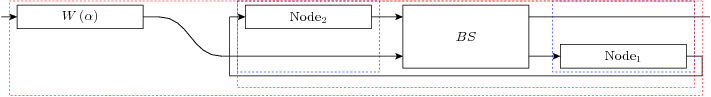

In [4]:
circuit.show()

In [5]:
slh = single_sided_network.network_slh(n_cavity=2, n_nodes=2, topology='driven_bs_fb')

In [6]:
slh.S

[[1]]

In [7]:
slh.L

[[-sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₁) - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₂)]]

In [8]:
def plot_bs_decay():
    from qnet.algebra.pattern_matching import pattern, wc
    from qnet.algebra.operator_algebra import ScalarTimesOperator
    θ = Symbol('theta', real=True)
    κ = Symbol('kappa', positive=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    theta = np.linspace(0, 2*np.pi, 100)
    L = slh.L[0, 0]
    k1_form, k2_form = [op.coeff for op in pattern(ScalarTimesOperator).findall(L)]
    k1_form = k1_form / sympy.sqrt(2*κ)
    k2_form = k2_form / sympy.sqrt(2*κ)
    k1 = np.array([k1_form.subs({θ: val}) for val in theta])
    k2 = np.array([k2_form.subs({θ: val}) for val in theta])
    ax.plot(theta/np.pi, k1)
    ax.plot(theta/np.pi, k2)
    ax.set_ylim(-3, 3)
    ax.set_xlabel(r'BS mixing angle $\theta$ ($\pi$ rad)')
    ax.set_ylabel(r'decay rate relative to open network')
    plt.show(fig)

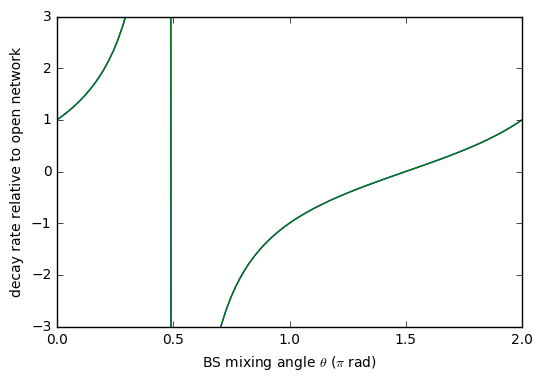

In [9]:
plot_bs_decay()

In [10]:
θ = Symbol('theta', real=True)
slh.L.substitute({θ: 3*pi/2}).simplify_scalar()

[[0]]

In [11]:
display_hamiltonian(slh.H)

<IPython.core.display.Latex object>

In [12]:
me = slh.symbolic_master_equation()

In [13]:
me

-1/2 * (ρ̂^(q₁⊗c₁⊗q₂⊗c₂) ⊗ (-sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₁)† - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₂)†) (-sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₁) - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₂)) + (-sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₁)† - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₂)†) (-sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₁) - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₂)) ⊗ ρ̂^(q₁⊗c₁⊗q₂⊗c₂)) - ⅈ * (-ρ̂^(q₁⊗c₁⊗q₂⊗c₂) (g_1**2/Δ_1 * Π̂_g^(q₁) ⊗ â^(c₁)† â^(c₁) - I*Ω_1*g_1/(2*Δ_1) * σ̂_e,g^(q₁) ⊗ â^(c₁) + I*Ω_1*g_1/(2*Δ_1) * σ̂_g,e^(q₁) ⊗ â^(c₁)† + sqrt(2)*I*λ*cos(θ)*conjugate(Ω_α)/(2*(sin(θ) - 1)) * â^(c₁)† - sqrt(2)*I*Ω_α*λ*cos(θ)/(2*sin(θ) - 2) * â^(c₁) - g_1**2/Δ_1 * â^(c₁)† â^(c₁) + ⅈ⋅κ * â^(c₁)† ⊗ â^(c₂) - ⅈ⋅κ * â^(c₁) ⊗ â^(c₂)† + g_2**2/Δ_2 * Π̂_g^(q₂) ⊗ â^(c₂)† â^(c₂) - I*Ω_2*g_2/(2*Δ_2) * σ̂_e,g^(q₂) ⊗ â^(c₂) + I*Ω_2*g_2/(2*Δ_2) * σ̂_g,e^(q₂) ⊗ â^(c₂)† + sqrt(2)*I*λ*cos(θ)*conjugate(Ω_α)/(2*(sin(θ) - 1)) * â^(c₂)† - sqr

## Numerical Values

In [14]:
controls = sorted([sym for sym in slh.H.all_symbols() if sym.name.startswith('Omega')], key=str)

In [15]:
# from algebra import generate_num_vals_code
# generate_num_vals_code(slh.all_symbols())

In [16]:
Delta =  5000.0  # MHz
g     =    50.0  # MHz
kappa =     0.5  # MHz
E0    =    70.0  # MHz
t0    = -4    # microsec
T     =  4    # microsec
nt    = 2001
theta = 1.5 * np.pi
num_vals = {
    Symbol('Delta_1', real=True):   Delta,
    Symbol('Delta_2', real=True):   Delta,
    Symbol('g_2', positive=True):   g,
    Symbol('g_1', positive=True):   g,
    Symbol('kappa', positive=True): kappa,
    Symbol('theta', real=True):     theta,
}

## Magnitude of coefficients

In [17]:
from qnet.algebra.pattern_matching import pattern
from qnet.algebra.operator_algebra import ScalarTimesOperator

In [18]:
{str(t.coeff): t.coeff.subs(num_vals) for t in pattern(head=ScalarTimesOperator).findall(slh.H)}

{'-I*Omega_1*g_1/(2*Delta_1)': -0.005*I*Omega_1,
 '-I*Omega_2*g_2/(2*Delta_2)': -0.005*I*Omega_2,
 '-I*kappa': -0.5*I,
 '-g_1**2/Delta_1': -0.500000000000000,
 '-g_2**2/Delta_2': -0.500000000000000,
 '-sqrt(2)*I*Omega_alpha*lambda*cos(theta)/(2*sin(theta) - 2)': -4.59242549680257e-17*sqrt(2)*I*Omega_alpha*lambda,
 'I*Omega_1*g_1/(2*Delta_1)': 0.005*I*Omega_1,
 'I*Omega_2*g_2/(2*Delta_2)': 0.005*I*Omega_2,
 'I*kappa': 0.5*I,
 'g_1**2/Delta_1': 0.500000000000000,
 'g_2**2/Delta_2': 0.500000000000000,
 'sqrt(2)*I*lambda*cos(theta)*conjugate(Omega_alpha)/(2*(sin(theta) - 1))': 4.59242549680257e-17*sqrt(2)*I*lambda*conjugate(Omega_alpha)}

## Time Grid and Guess Pulse

In [19]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec

In [20]:
p = QDYN.pulse.Pulse(
    tgrid, amplitude=(E0 * blackman(tgrid, t0, T)),
    time_unit='microsec', ampl_unit='MHz')

In [21]:
pa = QDYN.pulse.Pulse(
    tgrid, amplitude=(0.0 * blackman(tgrid, t0, T)),
    time_unit='microsec', ampl_unit='MHz')

In [22]:
controls = OrderedDict([
    (Symbol('Omega_1'), p.copy()),
    (Symbol('Omega_2'), p.copy()),
    (Symbol('Omega_a'), pa.copy()),
])

## OCT for forward transfer (hs)

In [25]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='excitation_transfer_fw',
    lambda_a=1e-4)

TypeError: Scalar coefficient '4.59242549680257e-17*sqrt(2)*I*lambda*conjugate(Omega_alpha)' is not numerical

In [26]:
data_root = "data/DR_BS_FB/"

In [ ]:
model.write_to_runfolder(data_root+"fw_oct_hs001/")

##  OCT for $\sqrt{SWAP}$ (hs)

In [ ]:
sqrt_SWAP = QDYN.gate2q.Gate2Q([
    [1,             0,             0,   0],
    [0, -1/np.sqrt(2),  1/np.sqrt(2),   0],
    [0, -1/np.sqrt(2), -1/np.sqrt(2),   0],
    [0,             0,             0, -1j]]
)

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-4)

In [ ]:
model.write_to_runfolder("./DR_BS_FB/sqrtSWAP_oct_hs001/")
sqrt_SWAP.write("./DR_BS_FB/sqrtSWAP_oct_hs001/target_gate.dat")

##  OCT for SWAP (hs)

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-2)

In [ ]:
model.write_to_runfolder("./DR_BS_FB/SWAP_oct_hs001/")
QDYN.gate2q.SWAP.write("./DR_BS_FB/SWAP_oct_hs001/target_gate.dat")

##  OCT for PE (hs)

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-2)

In [ ]:
model.write_to_runfolder("./DR_BS_FB/PE_oct_hs001/")
QDYN.gate2q.CPHASE.write("./DR_BS_FB/PE_oct_hs001/target_gate.dat")

##  OCT for sqrtSWAP (LI, hs)

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-4)

In [ ]:
model.write_to_runfolder("./DR_BS_FB/sqrtSWAP_oct_hsLI001/")
QDYN.gate2q.sqrt_SWAP.write("./DR_BS_FB/sqrtSWAP_oct_hsLI001/target_gate.dat")

##  OCT for sqrtSWAP (hs, dissipative)

In [ ]:
slh = single_sided_network.network_slh(n_cavity=2, n_nodes=2, topology='bs_fb')

In [ ]:
sqrt_SWAP = QDYN.gate2q.Gate2Q([
    [1,             0,             0,   0],
    [0, -1/np.sqrt(2),  1/np.sqrt(2),   0],
    [0, -1/np.sqrt(2), -1/np.sqrt(2),   0],
    [0,             0,             0, -1j]]
)

In [ ]:
num_vals_diss = num_vals.copy()
θ = Symbol('theta', real=True)
num_vals_diss[θ] = 0.25 * np.pi

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals_diss, controls, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='gate',
    lambda_a=1e-4)

In [ ]:
model.write_to_runfolder("./DR_BS_FB/sqrtSWAP_diss_oct_hs001/")
sqrt_SWAP.write("./DR_BS_FB/sqrtSWAP_diss_oct_hs001/target_gate.dat")

##  OCT for forward transfer (hs, dissipative)

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals_diss, controls, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='excitation_transfer_fw',
    lambda_a=1e-4)

In [ ]:
L = model.lindblad_ops()[0]

In [ ]:
model.write_to_runfolder("./DR_BS_FB/fw_diss_oct_hs001/")

##  OCT for dicke state initialization (hs, dissipative)

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals_diss, controls, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='dicke',
    lambda_a=1e-4)

In [ ]:
model.write_to_runfolder("./DR_BS_FB/dicke_diss_oct_hs001/")

## Example optimization commands

*   hilbert space optimization

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --debug --J_T=J_T_re .```

*   trajectory optimization (model with `mcwf=True`)

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --n-trajs=20 --J_T=J_T_re .```